# Requires gwbench

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from gwbench import network

import astropy.cosmology as cosmo
import astropy.units as u
import h5py

In [2]:
Nobs = 1000

# Make Population Distribution

Masses of Neutron Stars (source frame) in NS-NS binary are assumed to be $m_1=m_2=N(1.35M_{\odot},0.15M_{\odot})$.

Chirp mass (source frame) distribution is assumed to be (https://arxiv.org/pdf/1108.5161v2.pdf),

$$
M_c \approx N(2(0.25)^{0.6}1.35M_{\odot}, \sqrt{2}(0.25)^{0.6}0.15M_{\odot}) \approx N(1.17M_{\odot}, 0.10M_{\odot})
$$

(array([ 13.,  23.,  82., 135., 235., 236., 174.,  73.,  24.,   5.]),
 array([0.97972636, 1.01829809, 1.05686981, 1.09544154, 1.13401327,
        1.172585  , 1.21115673, 1.24972846, 1.28830019, 1.32687192,
        1.36544365]),
 <a list of 10 Patch objects>)

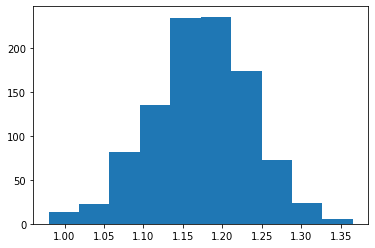

In [3]:
mean = 1.35 # in solar mass unit
std = 0.10

m1 = np.random.normal(mean, std, Nobs)
m2 = np.random.normal(mean, std, Nobs)

Mc = (m1*m2)**(0.6)/(m1+m2)**0.2
plt.hist(Mc)

(array([  2.,  20., 135., 277., 316., 173.,  57.,  16.,   2.,   2.]),
 array([0.65494133, 0.73832976, 0.8217182 , 0.90510663, 0.98849506,
        1.0718835 , 1.15527193, 1.23866037, 1.3220488 , 1.40543723,
        1.48882567]),
 <a list of 10 Patch objects>)

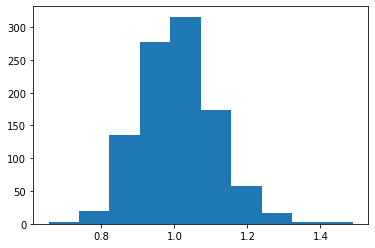

In [4]:
q = m2/m1
plt.hist(q)

(array([  1.,   1.,   2.,   0.,   0.,   7.,  17.,  35., 123., 814.]),
 array([0.23913172, 0.24021855, 0.24130538, 0.24239221, 0.24347903,
        0.24456586, 0.24565269, 0.24673952, 0.24782634, 0.24891317,
        0.25      ]),
 <a list of 10 Patch objects>)

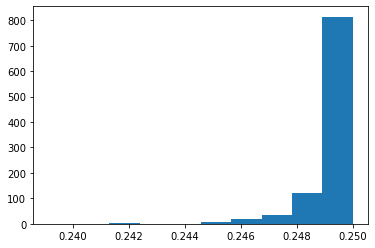

In [5]:
eta = m1*m2/((m1+m2)**2)
plt.hist(eta)

(array([ 62., 198., 239., 189., 136.,  87.,  55.,  21.,   8.,   5.]),
 array([1.33434995, 2.15841141, 2.98247287, 3.80653433, 4.63059579,
        5.45465725, 6.27871871, 7.10278017, 7.92684163, 8.75090309,
        9.57496455]),
 <a list of 10 Patch objects>)

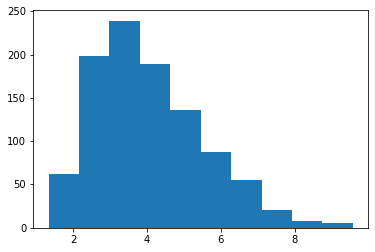

In [6]:
z = np.random.beta(3, 9, Nobs)*10 # z_max = 10
Mcz = Mc*(1+z)
plt.hist(Mcz)

(array([130., 255., 226., 154., 109.,  68.,  30.,  18.,   7.,   3.]),
 array([ 1.13169436,  8.16780283, 15.2039113 , 22.24001978, 29.27612825,
        36.31223672, 43.34834519, 50.38445367, 57.42056214, 64.45667061,
        71.49277908]),
 <a list of 10 Patch objects>)

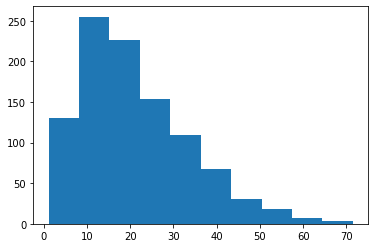

In [7]:
cp = cosmo.Planck18
DL = cp.luminosity_distance(z).to(u.Gpc).value # in Gpc
plt.hist(DL)

In [8]:
file = h5py.File('sky_position_1000.h5', 'r')
ra = np.array(file['ra'])
dec = np.array(file['dec'])
theta_jn = np.array(file['theta_jn'])
psi = np.array(file['psi'])

# Make Covariance Matrices

In [9]:
network_spec = ['aLIGO_H','aLIGO_L','aLIGO_V']
net = network.Network(network_spec)

wf_model_name = 'tf2'
net.set_wf_vars(wf_model_name = wf_model_name)

In [10]:
deriv_symbs_string = 'Mc DL' # eta tc phic iota ra dec psi
conv_cos = ('iota','dec')
conv_log = ('Mc','DL')
use_rot = 0
        

with h5py.File("cov_1000.h5", "w") as file:
    for i in range(Nobs):
        print('Nobs = ', i)
        
        inj_params = {
    'Mc':    Mcz[i],
    'eta':   eta[i],
    'chi1z': 0,
    'chi2z': 0,
    'DL':    DL[i]*10**3, # in Mpc
    'tc':    0,
    'phic':  0,
    'iota':  theta_jn[i],
    'ra':    ra[i],
    'dec':   dec[i],
    'psi':   psi[i],
    'gmst0': 0
    }
        
        M = Mc[i]/(eta[i]**0.6)
        f = np.arange(5., 4400/M, 2**-4)
        
        
        net.set_net_vars(
    f=f, inj_params=inj_params,
    deriv_symbs_string=deriv_symbs_string,
    conv_cos=conv_cos, conv_log=conv_log,
    use_rot=use_rot
    )
        
        net.calc_wf_polarizations_derivs_num()
        net.setup_ant_pat_lpf_psds()
        net.calc_det_responses_derivs_num()
        net.calc_snrs()
        net.calc_errors()
        
        snr = net.get_snrs_errs_cov_fisher_inv_err_for_key(key="network")[0]
        cov = net.get_snrs_errs_cov_fisher_inv_err_for_key(key="network")[2]
        
        print('Nobs=', i, 'Mcz=', Mcz[i], 'DL=', DL[i], 'eta=', eta[i], 'snr=', snr, 'cov=', cov)
        
        file.create_dataset('Mcz'+str(i), data = Mcz[i])
        file.create_dataset('DL'+str(i), data = DL[i])
        file.create_dataset('eta'+str(i), data = eta[i])
        file.create_dataset('q'+str(i), data = q[i])
        file.create_dataset('snr'+str(i), data = snr)
        file.create_dataset('cov'+str(i), data = cov)
file.close()

Nobs =  0
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 0 Mcz= 3.6867505795686957 DL= 15.25657933140663 eta= 0.24920269528056133 snr= 0.14477088195002655 cov= [[2.29449312e-05 1.99850682e-05]
 [1.99850682e-05 4.75351696e+01]]
Nobs =  1
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov ma

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 13 Mcz= 3.9707263401946116 DL= 18.681188118786395 eta= 0.2499302937197485 snr= 0.19963938168626216 cov= [[1.54749403e-05 1.39809238e-05]
 [1.39809238e-05 2.50025558e+01]]
Nobs =  14
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 14 Mcz= 5.848737436235238 DL= 37.75966824269667 eta= 0.24961984670117995 snr= 0.1936014314761882 cov= [[6.07390654e-05 5.20812930e-05]
 [5.20812930e-05 2.68256613e+01]]
Nobs =  

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 27 Mcz= 4.792857613183037 DL= 28.015118827362862 eta= 0.24998392609082742 snr= 0.0915176295153632 cov= [[1.38676315e-04 1.38978006e-04]
 [1.38978006e-04 1.19536314e+02]]
Nobs =  28
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 28 Mcz= 3.021210647

  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 40 Mcz= 4.605870034799204 DL= 26.726918140572256 eta= 0.24967485598990682 snr= 0.19861695910734786 cov= [[2.57517402e-05 1.93692966e-05]
 [1.93692966e-05 2.52926554e+01]]
Nobs =  41
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 41 Mcz= 4.2011562771477475 DL= 20.674410105170004 eta= 0.2494563236391072 snr= 0.11135973474340663 cov= [[6.01161012e-05 5.51495692e-05]
 [5.51495692e-05 8.05528344e+01]]
Nobs =  42
Calcu

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 54 Mcz= 3.547789739272321 DL= 16.127517333124867 eta= 0.24933231704770945 snr= 0.3889138894050823 cov= [[2.79571878e-06 2.48780213e-06]
 [2.48780213e-06 6.61333420e+00]]
Nobs =  55
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 55 Mcz= 3.217241155

  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 67 Mcz= 1.6584041145216206 DL= 1.5590559435395934 eta= 0.24990194151797518 snr= 1.2459310042233154 cov= [[2.15447087e-08 1.56218883e-08]
 [1.56218883e-08 6.44270562e-01]]
Nobs =  68
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 68 Mcz= 5.65950872024474 DL= 33.00638011417544 eta= 0.24996921078317805 snr= 0.4439523606861609 cov= [[1.03301411e-05 1.11610804e-05]
 [1.11610804e-05 5.06367720e+00]]
Nobs =  69
Calculat

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 81 Mcz= 3.2432611671920655 DL= 12.348839128656207 eta= 0.2494208101905491 snr= 0.45878321174266307 cov= [[1.48745428e-06 9.48163931e-07]
 [9.48163931e-07 4.74889689e+00]]
Nobs =  82
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 82 Mcz= 3.55712292

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 94 Mcz= 4.420240716362508 DL= 30.021866128079093 eta= 0.2499929902749742 snr= 0.21506022402709865 cov= [[1.91269195e-05 1.85897871e-05]
 [1.85897871e-05 2.15720846e+01]]
Nobs =  95
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 95 Mcz= 4.415233712720043 DL= 25.974183673963175 eta= 0.24987432388558756 snr= 0.21179833135381143 cov= [[1.96431100e-05 1.27195742e-05]
 [1.27195742e-05 2.22868955e+01]]
Nobs = 

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 108 Mcz= 2.029575892519886 DL= 5.761817562850035 eta= 0.2494940803943204 snr= 0.6935724286542074 cov= [[1.36234121e-07 1.30155698e-07]
 [1.30155698e-07 2.07786981e+00]]
Nobs =  109
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 109 Mcz= 4.57405226

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 121 Mcz= 7.145363591957815 DL= 46.39061921106445 eta= 0.24950777528984064 snr= 0.2036360490742419 cov= [[1.08496542e-04 8.21455045e-05]
 [8.21455045e-05 2.42029676e+01]]
Nobs =  122
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 122 Mcz= 7.233830755575155 DL= 44.76788789953873 eta= 0.2499177397304542 snr= 0.19485381376735733 cov= [[1.23548520e-04 1.15633135e-04]
 [1.15633135e-04 2.65308410e+01]]
Nobs = 

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 135 Mcz= 2.7496549914341815 DL= 9.28385076087504 eta= 0.24817114584603864 snr= 0.6545241880131246 cov= [[4.21001052e-07 2.74760779e-07]
 [2.74760779e-07 2.33365427e+00]]
Nobs =  136
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 136 Mcz= 4.2469038

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 148 Mcz= 4.22902523165904 DL= 24.831113440841662 eta= 0.24960743302137484 snr= 0.24707674444523395 cov= [[1.24886515e-05 1.27908585e-05]
 [1.27908585e-05 1.64203235e+01]]
Nobs =  149
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 149 Mcz= 2.3876833412598923 DL= 6.828961687174869 eta= 0.24999585865101723 snr= 0.42824605031826235 cov= [[6.13941221e-07 3.21384297e-07]
 [3.21384297e-07 5.44848759e+00]]
Nobs

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 162 Mcz= 3.535430395275087 DL= 20.991613833570675 eta= 0.24979292266828404 snr= 0.38325008372093083 cov= [[2.84606352e-06 1.93030290e-06]
 [1.93030290e-06 6.79927557e+00]]
Nobs =  163
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 163 Mcz= 3.84331

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 175 Mcz= 3.66519306986657 DL= 18.33175304680338 eta= 0.24991307735126903 snr= 0.333999265363044 cov= [[4.22739981e-06 3.88423534e-06]
 [3.88423534e-06 8.96756675e+00]]
Nobs =  176
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 176 Mcz= 3.6918727976686205 DL= 18.163448398464823 eta= 0.24939139304882166 snr= 0.4604089057257503 cov= [[2.27965779e-06 1.37963927e-06]
 [1.37963927e-06 4.67986389e+00]]
Nobs = 

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 189 Mcz= 4.864047764114663 DL= 25.200610789662623 eta= 0.24999695825088056 snr= 0.14478938704088112 cov= [[5.82149789e-05 4.08540338e-05]
 [4.08540338e-05 4.74240755e+01]]
Nobs =  190
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 190 Mcz= 2.03603

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 202 Mcz= 6.315350792784175 DL= 37.98258033341911 eta= 0.24951596927711958 snr= 0.1846652425916309 cov= [[8.66186071e-05 7.66586751e-05]
 [7.66586751e-05 2.95147242e+01]]
Nobs =  203
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 203 Mcz= 3.448646184123863 DL= 15.781616361172073 eta= 0.2498118497000019 snr= 0.2492637348574777 cov= [[6.18917470e-06 2.55216943e-06]
 [2.55216943e-06 1.60203209e+01]]
Nobs = 

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 216 Mcz= 3.1277040224881207 DL= 16.224587955032582 eta= 0.2491722167153857 snr= 0.5114227407778161 cov= [[1.06067343e-06 1.83717601e-06]
 [1.83717601e-06 3.82912460e+00]]
Nobs =  217
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 217 Mcz= 5.915631

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 229 Mcz= 2.9724293696532773 DL= 10.704371417888561 eta= 0.24990077119277562 snr= 0.7098840727423927 cov= [[4.64141022e-07 2.26969872e-07]
 [2.26969872e-07 1.98434003e+00]]
Nobs =  230
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 230 Mcz= 6.520473425457847 DL= 42.90122892417587 eta= 0.24973226185523967 snr= 0.23426734511793185 cov= [[6.00048747e-05 7.00672317e-05]
 [7.00672317e-05 1.82777564e+01]]
Nobs

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 243 Mcz= 3.0732261281369526 DL= 12.481881678910677 eta= 0.24832095851323369 snr= 0.5345628912231271 cov= [[9.15353036e-07 7.45221494e-07]
 [7.45221494e-07 3.49488707e+00]]
Nobs =  244
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 244 Mcz= 2.25708

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 256 Mcz= 5.303808572462018 DL= 32.47195077593905 eta= 0.24900005511138357 snr= 0.11595148169201105 cov= [[1.21635408e-04 9.11564918e-05]
 [9.11564918e-05 7.45907224e+01]]
Nobs =  257
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 257 Mcz= 1.8068047313175397 DL= 3.480337603879112 eta= 0.24794989768760056 snr= 0.6370872052190912 cov= [[1.09640777e-07 7.51633518e-08]
 [7.51633518e-08 2.46446597e+00]]
Nobs 

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 270 Mcz= 5.372371616857964 DL= 32.04865458428246 eta= 0.24974509904350564 snr= 0.23831429383528663 cov= [[3.00634592e-05 2.22058287e-05]
 [2.22058287e-05 1.75239609e+01]]
Nobs =  271
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 271 Mcz= 3.429133

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 283 Mcz= 4.314180517018318 DL= 21.855127207717384 eta= 0.24997914532133728 snr= 0.11140582477589449 cov= [[6.56650805e-05 4.53591296e-05]
 [4.53591296e-05 8.08148711e+01]]
Nobs =  284
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 284 Mcz= 5.027345647194467 DL= 27.215575323741433 eta= 0.2499056438743803 snr= 0.21734566414470405 cov= [[2.88806885e-05 3.17842344e-05]
 [3.17842344e-05 2.11988745e+01]]
Nobs

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 297 Mcz= 3.0447857212159897 DL= 12.846184099978705 eta= 0.24999791248445843 snr= 0.4033713905878968 cov= [[1.55805908e-06 1.61081302e-06]
 [1.61081302e-06 6.15211360e+00]]
Nobs =  298
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 298 Mcz= 5.57003

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 310 Mcz= 2.697914942438592 DL= 7.220938805568054 eta= 0.24978733973973477 snr= 0.7301831428562129 cov= [[3.17336811e-07 2.98494926e-07]
 [2.98494926e-07 1.87400682e+00]]
Nobs =  311
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 311 Mcz= 3.1953652360668414 DL= 12.631545768629143 eta= 0.24990383841053965 snr= 0.3771990390731618 cov= [[2.09361863e-06 1.64734963e-06]
 [1.64734963e-06 7.01911619e+00]]
Nobs 

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 324 Mcz= 1.6002252480414132 DL= 1.7325282021444526 eta= 0.2491386420143239 snr= 0.6912358865551821 cov= [[6.21691001e-08 5.37747515e-08]
 [5.37747515e-08 2.09147704e+00]]
Nobs =  325
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 325 Mcz= 4.981023

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 337 Mcz= 2.0617682472101166 DL= 3.4215142241601963 eta= 0.24988989342736118 snr= 0.877147751168138 cov= [[8.97146554e-08 8.13810078e-08]
 [8.13810078e-08 1.30069245e+00]]
Nobs =  338
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 338 Mcz= 4.80187366604404 DL= 29.768460388673443 eta= 0.24990737469544294 snr= 0.1903173497814137 cov= [[3.22736229e-05 2.55605532e-05]
 [2.55605532e-05 2.74879192e+01]]
Nobs =

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 351 Mcz= 5.8072780359023985 DL= 33.29751673911805 eta= 0.24965089367493504 snr= 0.18341291239836885 cov= [[6.60489918e-05 5.44752336e-05]
 [5.44752336e-05 2.99283740e+01]]
Nobs =  352
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 352 Mcz= 3.63126

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 364 Mcz= 3.174988133134673 DL= 12.743490586529212 eta= 0.24873139628111457 snr= 0.5217940058079142 cov= [[1.07113664e-06 2.64676951e-07]
 [2.64676951e-07 3.66782564e+00]]
Nobs =  365
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 365 Mcz= 4.604451982382961 DL= 27.985117761023133 eta= 0.24836674755447044 snr= 0.09429362580764412 cov= [[1.14184634e-04 1.40117734e-04]
 [1.40117734e-04 1.12623193e+02]]
Nobs

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 378 Mcz= 2.432312598305551 DL= 8.780541356435801 eta= 0.2494663678760507 snr= 0.5216055045281061 cov= [[ 4.40307718e-07 -2.99568421e-07]
 [-2.99568421e-07  3.67138354e+00]]
Nobs =  379
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 379 Mcz= 2.7694

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 391 Mcz= 3.9622378866579 DL= 21.366396908751884 eta= 0.24987692588656243 snr= 0.4847892669694415 cov= [[2.60603405e-06 1.97258536e-06]
 [1.97258536e-06 4.24325266e+00]]
Nobs =  392
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 392 Mcz= 4.156172576628801 DL= 22.940905083337977 eta= 0.2487174398200158 snr= 0.45979688922310713 cov= [[3.40217133e-06 2.84534866e-06]
 [2.84534866e-06 4.72888348e+00]]
Nobs = 

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 405 Mcz= 3.1992111837281296 DL= 13.88339657878166 eta= 0.24785469887526793 snr= 0.3333025925352618 cov= [[2.69344771e-06 1.87936732e-06]
 [1.87936732e-06 8.98113255e+00]]
Nobs =  406
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 406 Mcz= 4.093665

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 418 Mcz= 4.440505330941819 DL= 22.128597633773975 eta= 0.24964616797458336 snr= 0.20155905803182603 cov= [[2.21061326e-05 1.78876126e-05]
 [1.78876126e-05 2.45540944e+01]]
Nobs =  419
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 419 Mcz= 3.683391977255486 DL= 19.55255543375692 eta= 0.24998972434519787 snr= 0.36233588181269366 cov= [[3.65234659e-06 2.36394010e-06]
 [2.36394010e-06 7.58656516e+00]]
Nobs

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 432 Mcz= 4.037920051091784 DL= 20.64512436144074 eta= 0.24805119373498266 snr= 0.21827131308256234 cov= [[1.37032939e-05 9.56222916e-06]
 [9.56222916e-06 2.08883983e+01]]
Nobs =  433
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 433 Mcz= 2.714630

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 445 Mcz= 3.788070525877936 DL= 20.564205868043317 eta= 0.2497118392847451 snr= 0.14690592417062767 cov= [[2.44087505e-05 1.56989344e-05]
 [1.56989344e-05 4.64101376e+01]]
Nobs =  446
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 446 Mcz= 5.815627991423077 DL= 33.46450169153471 eta= 0.24959911638722077 snr= 0.21228325276169802 cov= [[4.95473541e-05 3.36350076e-05]
 [3.36350076e-05 2.23155609e+01]]
Nobs 

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 459 Mcz= 3.7036549848425837 DL= 18.401425163888778 eta= 0.24998640783475332 snr= 0.22864614337789643 cov= [[9.34154379e-06 7.83973574e-06]
 [7.83973574e-06 1.91019265e+01]]
Nobs =  460
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 460 Mcz= 4.8532

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 472 Mcz= 5.4865591199757135 DL= 31.46104059416159 eta= 0.24999889162865693 snr= 0.26155873173115557 cov= [[2.67927481e-05 2.11274479e-05]
 [2.11274479e-05 1.46146968e+01]]
Nobs =  473
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 473 Mcz= 2.8577669681299542 DL= 11.104648497692114 eta= 0.24940464164567883 snr= 0.20907926708553543 cov= [[4.69262789e-06 9.80860707e-07]
 [9.80860707e-07 2.28469930e+01]]
No

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 486 Mcz= 5.3847019929708395 DL= 27.87786053051673 eta= 0.2498396423793022 snr= 0.05080262148570372 cov= [[6.66517435e-04 5.04686490e-04]
 [5.04686490e-04 3.85186672e+02]]
Nobs =  487
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 487 Mcz= 4.289978

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 499 Mcz= 3.3583369012369486 DL= 15.184899080931089 eta= 0.24953707205969267 snr= 0.2552005996596298 cov= [[5.40299881e-06 1.13705759e-05]
 [1.13705759e-05 1.53568415e+01]]
Nobs =  500
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 500 Mcz= 7.73586548811263 DL= 50.75535100366745 eta= 0.24719687370842863 snr= 0.08540529549314682 cov= [[8.10413118e-04 8.57456738e-04]
 [8.57456738e-04 1.38900433e+02]]
Nobs 

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 513 Mcz= 3.895942292704424 DL= 17.963304865347535 eta= 0.24914266239696414 snr= 0.43167978250830763 cov= [[3.10569542e-06 2.15686015e-06]
 [2.15686015e-06 5.31777997e+00]]
Nobs =  514
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 514 Mcz= 2.63536

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 526 Mcz= 4.691263566079809 DL= 24.860790144784854 eta= 0.24975446107660573 snr= 0.320058791268514 cov= [[1.05481487e-05 1.43827400e-05]
 [1.43827400e-05 9.75106020e+00]]
Nobs =  527
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 527 Mcz= 3.353855580466651 DL= 15.496983925504852 eta= 0.24926830276666492 snr= 0.29614354582156305 cov= [[3.99470522e-06 3.07728413e-06]
 [3.07728413e-06 1.13412500e+01]]
Nobs 

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 540 Mcz= 2.322957286684866 DL= 6.85046507753048 eta= 0.24997810752287222 snr= 0.8890082106847895 cov= [[1.29999384e-07 9.06398601e-08]
 [9.06398601e-08 1.26406145e+00]]
Nobs =  541
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 541 Mcz= 4.83269641

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 553 Mcz= 2.260012260665558 DL= 6.815889893364336 eta= 0.24945379848588656 snr= 0.29473546673892975 cov= [[1.07937207e-06 7.41808925e-07]
 [7.41808925e-07 1.15013546e+01]]
Nobs =  554
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 554 Mcz= 4.438177963192624 DL= 23.741475273716784 eta= 0.2488165816438089 snr= 0.10627731965810458 cov= [[7.93983331e-05 7.90800034e-05]
 [7.90800034e-05 8.75757355e+01]]
Nobs 

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 567 Mcz= 3.9894557119140313 DL= 18.32899280064352 eta= 0.24894287384579925 snr= 0.34575898957349444 cov= [[5.24219830e-06 4.09263407e-06]
 [4.09263407e-06 8.34639762e+00]]
Nobs =  568
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 568 Mcz= 7.41833

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 580 Mcz= 2.0273436859105427 DL= 4.114622863248458 eta= 0.24879861393080363 snr= 0.715387354222044 cov= [[1.27558674e-07 7.11681459e-08]
 [7.11681459e-08 1.95292726e+00]]
Nobs =  581
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 581 Mcz= 2.018793947576592 DL= 4.567685968311204 eta= 0.24991253460051924 snr= 0.5259281295016999 cov= [[2.32715814e-07 1.49268769e-07]
 [1.49268769e-07 3.61029947e+00]]
Nobs = 

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 594 Mcz= 4.167855717125985 DL= 16.73338342098838 eta= 0.24976737399557694 snr= 0.28339662395566045 cov= [[9.03368576e-06 7.01605084e-06]
 [7.01605084e-06 1.24230254e+01]]
Nobs =  595
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 595 Mcz= 2.528182

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 607 Mcz= 3.7665033992800776 DL= 18.501678295422163 eta= 0.2490767203293209 snr= 0.20870892084193435 cov= [[1.18641231e-05 3.85953532e-06]
 [3.85953532e-06 2.29091074e+01]]
Nobs =  608
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 608 Mcz= 3.300017608202562 DL= 14.470468246787245 eta= 0.24985556554422822 snr= 0.22680024613592875 cov= [[6.45084594e-06 5.11985443e-06]
 [5.11985443e-06 1.94513032e+01]]
Nob

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 621 Mcz= 3.21182237603218 DL= 13.955457750277406 eta= 0.24907959787297557 snr= 0.2678225562354797 cov= [[4.22586101e-06 5.00071955e-06]
 [5.00071955e-06 1.39082357e+01]]
Nobs =  622
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 622 Mcz= 2.4107568

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 634 Mcz= 2.729391014988648 DL= 10.99921688405255 eta= 0.24999575918481165 snr= 0.6016937385886515 cov= [[4.85995888e-07 3.26258245e-07]
 [3.26258245e-07 2.75917713e+00]]
Nobs =  635
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 635 Mcz= 1.8284641095809047 DL= 5.133550574889095 eta= 0.2499771518280094 snr= 0.48046872881061614 cov= [[2.00580195e-07 1.48116519e-07]
 [1.48116519e-07 4.32769755e+00]]
Nobs =

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 648 Mcz= 1.607415301774669 DL= 3.324483712892027 eta= 0.24896940157357772 snr= 0.3970101780197508 cov= [[1.91358115e-07 1.13337849e-07]
 [1.13337849e-07 6.34451980e+00]]
Nobs =  649
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 649 Mcz= 3.0828557

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 661 Mcz= 8.963664225565307 DL= 58.85099133920167 eta= 0.2499335185888134 snr= 0.16338525889694677 cov= [[3.67060966e-04 4.15345810e-04]
 [4.15345810e-04 3.77695796e+01]]
Nobs =  662
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 662 Mcz= 4.149080510363021 DL= 22.783835189392978 eta= 0.24951070150987975 snr= 0.4358530720061237 cov= [[3.76383499e-06 2.26306228e-06]
 [2.26306228e-06 5.25615673e+00]]
Nobs =

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 675 Mcz= 2.3492487778717726 DL= 6.022552530745522 eta= 0.2498619410290341 snr= 0.6718604946057948 cov= [[2.36280408e-07 1.94582114e-07]
 [1.94582114e-07 2.21191159e+00]]
Nobs =  676
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 676 Mcz= 5.1751147

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 688 Mcz= 3.9069947012129704 DL= 19.242672200638786 eta= 0.2496899954343634 snr= 0.5546944682917035 cov= [[1.89884361e-06 9.71061298e-07]
 [9.71061298e-07 3.22902550e+00]]
Nobs =  689
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 689 Mcz= 3.5344991113882473 DL= 16.899247643708097 eta= 0.24967328998142277 snr= 0.3098978611284913 cov= [[4.34813577e-06 3.62007371e-06]
 [3.62007371e-06 1.04026529e+01]]
Nobs

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 702 Mcz= 4.497671378475297 DL= 25.176535973843485 eta= 0.24940916707457955 snr= 0.2311739211503347 cov= [[1.75480179e-05 1.01209804e-05]
 [1.01209804e-05 1.85907431e+01]]
Nobs =  703
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 703 Mcz= 5.978446

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 715 Mcz= 5.985596526102056 DL= 40.859861958531916 eta= 0.24963727028143837 snr= 0.27199777979967643 cov= [[3.32847302e-05 2.70790632e-05]
 [2.70790632e-05 1.35696899e+01]]
Nobs =  716
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 716 Mcz= 6.33675635086468 DL= 40.7430918519654 eta= 0.249544718146285 snr= 0.06035899936405305 cov= [[8.20230496e-04 8.01149943e-04]
 [8.01149943e-04 2.78213637e+02]]
Nobs =  

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 729 Mcz= 6.627731907594121 DL= 48.476797876869085 eta= 0.24927223392586303 snr= 0.09676499990641789 cov= [[3.71918059e-04 3.96621165e-04]
 [3.96621165e-04 1.06738311e+02]]
Nobs =  730
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 730 Mcz= 2.36021

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 742 Mcz= 5.635951600938199 DL= 36.27766483772412 eta= 0.248598081100939 snr= 0.2476568679867954 cov= [[3.27512273e-05 3.68050219e-05]
 [3.68050219e-05 1.63646763e+01]]
Nobs =  743
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 743 Mcz= 4.039490963859053 DL= 23.34014252028557 eta= 0.2499310891997956 snr= 0.17387547941795625 cov= [[2.16163883e-05 1.59863546e-05]
 [1.59863546e-05 3.29618558e+01]]
Nobs =  7

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 756 Mcz= 6.564801387415052 DL= 41.93904821106907 eta= 0.2499451508577832 snr= 0.3015861232477628 cov= [[3.70456355e-05 2.27026646e-05]
 [2.27026646e-05 1.10861573e+01]]
Nobs =  757
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 757 Mcz= 7.77660594

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 769 Mcz= 2.8387085753591 DL= 9.206182999770883 eta= 0.24938535078181157 snr= 0.43502729957084035 cov= [[1.05977309e-06 1.49353502e-06]
 [1.49353502e-06 5.26294158e+00]]
Nobs =  770
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 770 Mcz= 4.542211456571349 DL= 23.042269128296457 eta= 0.24999773875108633 snr= 0.13852181131250182 cov= [[5.05053620e-05 3.84870447e-05]
 [3.84870447e-05 5.21755147e+01]]
Nobs =

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 783 Mcz= 4.271222321406161 DL= 20.52641693962308 eta= 0.24987472363773075 snr= 0.2822000180012017 cov= [[9.89479500e-06 8.13928354e-06]
 [8.13928354e-06 1.25299592e+01]]
Nobs =  784
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 784 Mcz= 3.8012622

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 796 Mcz= 5.65483586006406 DL= 34.939686579745945 eta= 0.24995669716910807 snr= 0.14165283193682593 cov= [[1.01194312e-04 6.31685084e-05]
 [6.31685084e-05 5.05668762e+01]]
Nobs =  797
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 797 Mcz= 4.109566713934674 DL= 21.847585797298997 eta= 0.24998938310661029 snr= 0.19196377317001054 cov= [[1.87866580e-05 1.63234291e-05]
 [1.63234291e-05 2.71397459e+01]]
Nobs

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 810 Mcz= 7.789643207536235 DL= 53.91484950877237 eta= 0.24999900199018404 snr= 0.2865411132461242 cov= [[7.36196680e-05 5.33365454e-05]
 [5.33365454e-05 1.22702662e+01]]
Nobs =  811
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 811 Mcz= 5.8553969

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 823 Mcz= 6.679691629171117 DL= 47.83230985990089 eta= 0.24980861694618695 snr= 0.08890772852763262 cov= [[4.52310745e-04 4.26491022e-04]
 [4.26491022e-04 1.25875745e+02]]
Nobs =  824
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 824 Mcz= 4.111440501858819 DL= 22.309501424717013 eta= 0.24999882653852595 snr= 0.14345720760500516 cov= [[3.36913064e-05 2.82975460e-05]
 [2.82975460e-05 4.86024474e+01]]
Nobs

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 837 Mcz= 3.802926905188746 DL= 17.2823545153055 eta= 0.24995085770447972 snr= 0.30092581706657157 cov= [[5.89230690e-06 4.88987260e-06]
 [4.88987260e-06 1.09673225e+01]]
Nobs =  838
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 838 Mcz= 8.5925799

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 850 Mcz= 4.090005408448706 DL= 22.020051552170795 eta= 0.24806345998033147 snr= 0.1924473522717791 cov= [[1.84039651e-05 1.76234892e-05]
 [1.76234892e-05 2.70613832e+01]]
Nobs =  851
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 851 Mcz= 3.7871981385453406 DL= 19.19762017392836 eta= 0.24932153341940025 snr= 0.15196245459902338 cov= [[2.27938733e-05 2.13089988e-05]
 [2.13089988e-05 4.32855136e+01]]
Nobs

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 864 Mcz= 6.557422108286237 DL= 40.078365032464205 eta= 0.24999583528291763 snr= 0.2141788778511596 cov= [[7.31648935e-05 9.07476987e-05]
 [9.07476987e-05 2.20639979e+01]]
Nobs =  865
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 865 Mcz= 4.317689

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 877 Mcz= 2.922172542530847 DL= 10.356515166591725 eta= 0.2499979882160334 snr= 0.4548259053234176 cov= [[1.06803405e-06 9.57171118e-07]
 [9.57171118e-07 4.82729487e+00]]
Nobs =  878
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 878 Mcz= 5.662647329571145 DL= 39.32149249892477 eta= 0.2498608672400944 snr= 0.1302162819859112 cov= [[1.20334828e-04 1.29426755e-04]
 [1.29426755e-04 5.85162134e+01]]
Nobs =  

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 891 Mcz= 3.4043105778504517 DL= 14.855512461649436 eta= 0.24939581341571218 snr= 0.34177314516576085 cov= [[3.15264218e-06 2.96221147e-06]
 [2.96221147e-06 8.55539945e+00]]
Nobs =  892
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 892 Mcz= 3.8610

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 904 Mcz= 4.236595686033058 DL= 20.919319926145604 eta= 0.24954690664883064 snr= 0.27234066850319144 cov= [[1.03388157e-05 8.14956533e-06]
 [8.14956533e-06 1.35084528e+01]]
Nobs =  905
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 905 Mcz= 4.941167867343926 DL= 26.822137864771594 eta= 0.24991697224561565 snr= 0.05049032658626812 cov= [[5.04856381e-04 5.87733649e-04]
 [5.87733649e-04 3.91932055e+02]]
Nob

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 918 Mcz= 5.099680217478409 DL= 31.29865112941694 eta= 0.24897172309376503 snr= 0.3709042382620346 cov= [[1.04119026e-05 1.00269775e-05]
 [1.00269775e-05 7.22925162e+00]]
Nobs =  919
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 919 Mcz= 3.8177283

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 931 Mcz= 2.7299257354166895 DL= 10.04250653777347 eta= 0.24584643875330625 snr= 0.6436292863288959 cov= [[4.25212380e-07 3.09064117e-07]
 [3.09064117e-07 2.41087342e+00]]
Nobs =  932
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 932 Mcz= 3.9394875382210204 DL= 20.30104315379836 eta= 0.24993329895789265 snr= 0.27320730640464497 cov= [[8.04786866e-06 4.85291037e-06]
 [4.85291037e-06 1.33758397e+01]]
Nobs

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 945 Mcz= 3.2385969175632674 DL= 16.218223578975415 eta= 0.24977795325638094 snr= 0.13579337278284573 cov= [[1.69013934e-05 8.93123422e-06]
 [8.93123422e-06 5.39896716e+01]]
Nobs =  946
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 946 Mcz= 2.0633

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 958 Mcz= 3.143984964111649 DL= 14.154461226260223 eta= 0.24998810771751187 snr= 0.38457454777142197 cov= [[1.90809836e-06 1.98372648e-06]
 [1.98372648e-06 6.77386313e+00]]
Nobs =  959
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 959 Mcz= 6.594509941366287 DL= 42.863208182505645 eta= 0.24991022861174375 snr= 0.21089498762561162 cov= [[7.69345465e-05 5.63569452e-05]
 [5.63569452e-05 2.26155231e+01]]
Nob

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 972 Mcz= 3.3837287906553537 DL= 15.903659744722129 eta= 0.24680142473468678 snr= 0.3304599137183915 cov= [[3.30632589e-06 2.84181924e-06]
 [2.84181924e-06 9.14816359e+00]]
Nobs =  973
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 973 Mcz= 4.97616

  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 985 Mcz= 2.6075808404133953 DL= 10.415639155952324 eta= 0.24950398138096183 snr= 0.4661473830737772 cov= [[6.95348975e-07 3.15977375e-07]
 [3.15977375e-07 4.59580267e+00]]
Nobs =  986
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 986 Mcz= 3.642170904998946 DL= 16.67370092392149 eta= 0.24953925270701574 snr= 0.40241381117722647 cov= [[2.85126086e-06 1.04121585e-05]
 [1.04121585e-05 6.17524057e+00]]
Nobs

Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  aLIGO_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  aLIGO_V
Errors calculated.
Nobs= 999 Mcz= 3.314800755310514 DL= 14.448877615331586 eta= 0.24971867813561172 snr= 0.4798012561861133 cov= [[1.46312746e-06 1.69599613e-06]
 [1.69599613e-06 4.32601701e+00]]
